## LuSEE-Night Antenna tradeoffs

### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import scipy.special as sp

### collection of dipole antenna formulas

In [2]:
def rantsimp(l,lam):
    ''' return radiation resistance of an electrically-short diople'''
    Z0 = 376.730312
    return np.pi* Z0 *((l/lam)**2)/6

def rant(l,lam):
    '''3rd-order polynomial in kL
       dipole radiation resistance formula 
       from Huang, Antennas: from theory to practice'''
    betal = np.pi*l/lam
    f1= -.4787 + 7.3246*betal + .3963*betal**2 + 15.6131*betal**3
    return f1

def xantsimp(L,lam,a):
    '''reactance of an electrically-short dipole
       inputs: 
       l: length tip to tip
       lam: wavelength
       a: radius of conductors'''
    k = 2*np.pi/lam
    kL = k*L
    return -120*(np.log(L/2/a)-1)/tan(kL/2.)

def xant(l,lam,d):
    ''' approx formula for reactance of dipole from Huang '''
    betal = np.pi*l/lam
    f1= -.4787 + 7.3246*betal + .3963*betal**2 + 15.6131*betal**3
    f2 = -.4456 + 17.0082*betal - 8.6793*betal**2 + 9.6031*betal**3
    xant = f1 -(120*(np.log(2*l/d)-1)/tan(betal) - f2)
    return xant

def Zdipole(L,nu, a=.001, Rin=False):
    ''' return impedance of dipole of length L, radius a at frequency nu 
        using formulas 4-70 and 4-70a from Balanis 3rd edition
        if Rin=True (e.g. LuSEE case), uses Balanis 4-79 
        for impedance seen at the input terminals of the antenna'''
    c=299792458 #m/s
    lam = c/nu
    k = 2*np.pi/lam
    kL = k*L
    Z0 = 376.730312 # impedance of free space
    CikL=sp.sici(kL)[1]
    SikL=sp.sici(kL)[0]
    Ci2kL=sp.sici(2*kL)[1]
    Si2kL=sp.sici(2*kL)[0]
    # prefactor with sin^2 in denom is for feedpoint where I -> 0
    # see Balanis 
    prefactor = Z0/2/np.pi
    if (Rin):
        prefactor = Z0/2/np.pi/np.sin(0.5*kL)**2
    R = prefactor * (np.euler_gamma + np.log(kL) - CikL + 0.5*np.sin(kL) * (Si2kL - 2*SikL) + 0.5*np.cos(kL) * (np.euler_gamma + np.log(kL/2.) + Ci2kL - 2*CikL)) 
    X = 0.5*prefactor * (2.*SikL + np.cos(kL) * (2.*SikL - Si2kL) - np.sin(kL) * (2.*CikL - Ci2kL - sp.sici(2*k*a*a/L)[1]))
    return (R,X)

def zdipole(L,lam,a=.001, Rin=False):
    ''' return impedance of dipole of length L, radius a at wavelength lam '''
    k = 2*np.pi/lam
    kL = k*L
    Z0 = 376.730312 # impedance of free space
    CikL=sp.sici(kL)[1]
    CikL=sp.sici(kL)[1]
    SikL=sp.sici(kL)[0]
    Ci2kL=sp.sici(2*kL)[1]
    Si2kL=sp.sici(2*kL)[0]
    # prefactor with sin^2 in denom is for feedpoint where I -> 0
    # see Balanis 
    prefactor = Z0/2/np.pi
    if (Rin):
        prefactor = Z0/2/np.pi/np.sin(0.5*kL)**2
    R = prefactor * (np.euler_gamma + np.log(kL) - CikL + 0.5*np.sin(kL) * (Si2kL - 2*SikL) + 0.5*np.cos(kL) * (np.euler_gamma + np.log(kL/2.) + Ci2kL - 2*CikL)) 
    X = 0.5*prefactor * (2.*SikL + np.cos(kL) * (2.*SikL - Si2kL) - np.sin(kL) * (2.*CikL - Ci2kL - sp.sici(2*k*a*a/L)[1]))
    return (R,X)


### galactic sky brightness models and transformations

In [3]:
def B_NB(f):
    ''' return sky brightness (W/m**2/Hz/sr) at frequency f (MHz) 
        according to the model of Novaco and Brown 1978 ApJ 221 (1978): 114-123
	'''
    B0 = 1.36e-19
    plB = -0.76
    pltau = -0.64
    tau = 3.28 * f**pltau
    return B0 * f**plB * np.exp(-1.*tau)

def B_C(f):
    ''' return sky brightness (W/m**2/Hz/sr) at frequency f(MHz) 
        according to the model of Cane 1979 MNRAS 189.3 (1979): 465-478.
	'''
    Ig = 2.48e-20
    Ieg = 1.06e-20
    plg = -0.52
    pleg = -0.8
    pltau = -2.1
    tau = 5 * f**pltau
    return Ig * f**plg * (1 - np.exp(-1.*tau))/tau + Ieg * f**pleg * np.exp(-1.0 * tau)

def T2B(T, f):
    ''' return brightness temperature in W/m*2/Hz/sr from T in K and f in MHz) '''
    B = 2 * const.k_B * T*u.K * (f * u.MHz)**2 / (const.c)**2
    return B.to(u.W / u.m / u.m / u.Hz)

def B2T(B, f):
    ''' return brightness temperature in K from brightness in W/m*2/Hz/sr and f in MHz '''
    B_units = u.W / u.m / u.m / u.Hz
    T = B * B_units * (const.c)**2 / 2 / const.k_B / (f * u.MHz)**2
    return T.to(u.K)

def B2V(B, f, leff, gamma):
    ''' return V^2/Hz for dipole of effective length leff [m] and preamp coupling efficiency gamma c.f. Zaslavsky (11) '''
    return 4*np.pi / 3. * 377 * B * (leff*gamma)**2

### define gamma and leff 

In [4]:
Z0 = 376.730312
def gamma(L,f,a=.001, Rin=True, Cload=30e-12):
    '''Mismatch between antenna impedance looking into purely capacitive load'''
    zz = Zdipole(L,f, .001, Rin=Rin)
    zant = zz[0] + 1j*zz[1]
    gamma = ((1/2/np.pi/f/Cload))/(abs(1/2/np.pi/f/Cload + zant))
    return gamma
    
def leff(L,f,a=.001, Rin=True):
    ''' generalization of Eq. 6-26 in Volakis, Antenna Engineering Handbook
        where we use exact expression for radiation resistance of a short 
        dipole and take the directivity to be exactly 1.5 
        (for non-short dipole it increases, see Balanis Eq. 4-75, 4-75a, 
        and Fig. 4.9'''
    c=299792458 # speed of light
    zz = Zdipole(L,f, .001, Rin=Rin)
    zant = zz[0] + 1j*zz[1]
    leff = np.sqrt(1.5 * zz[0]/np.pi/Z0)*c/f
    return leff

print("{0:.2f}\t{1:.3f}\t{2:.3g}".format(gamma(10,3e6), leff(10,3e6), 4*np.pi/3*Z0*B_NB(3)))

0.54	5.033	1.84e-17


## plot transfer coefficients leff and gamma

In [5]:
c=299792458 # speed of light
L = np.arange(1,15,.1)
freq = np.array([1,2,5,10,20,50]) *1e6
Cload = 30e-12 # base capacitance

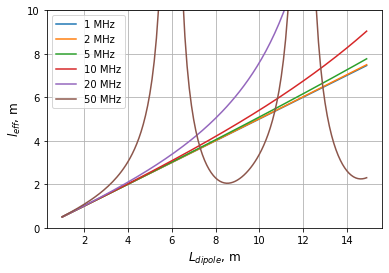

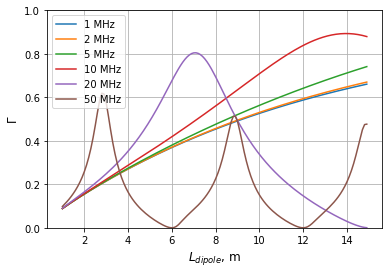

In [6]:
doPlot=False
fig = plt.figure()
for f in freq:
    label = str(np.int(f/1e6))+' MHz'
    plt.plot(L, leff(L,f), label=label)
    plt.ylim(0,10); plt.legend(); plt.grid(True)
    plt.xlabel('$L_{dipole}$, m', fontsize='large')
    plt.ylabel('$l_{eff}$, m', fontsize='large')
if(doPlot):
    plt.savefig('leff_vs_L.png')
    
fig=plt.figure()
for f in freq:
    label = str(np.int(f/1e6))+' MHz'
    plt.plot(L,gamma(L,f), label=label)
    plt.ylim(0,1); plt.legend(); plt.grid(True)
    plt.xlabel('$L_{dipole}$, m', fontsize='large')
    plt.ylabel('$\Gamma$', fontsize='large')
if(doPlot):
    plt.savefig('gamma_vs_L.png')


### look at overall transfer efficiency vs. L and $\lambda$

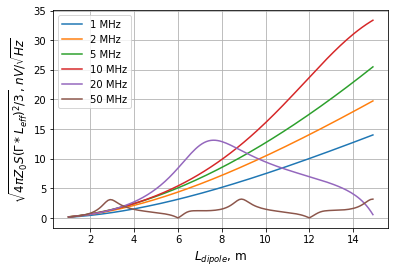

In [7]:
# loop over L for  freq
# plot V^2/Hz for galactic spectrum vs. L
doPlot=False
Z0 = 376.730312
fig=plt.figure()
for f in freq:
    label = str(np.int(f/1e6))+' MHz'
    # sky brightness, Novacco-Brown model
    BNB = B_NB(f/1e6)
    # resultant signal (V^2/Hz) ala Zaslavsky, Pulupa
    S_NB = 4*np.pi/3. * Z0 * BNB * (leff(L,f) * gamma(L,f))**2
    # plt.plot(L,np.sqrt(S_NB)/1e-9, label=label)
    plt.plot(L,np.sqrt((S_NB))/1e-9, label=label)
    # plt.ylim(0,40)
    plt.legend(); plt.grid(True)
    plt.xlabel('$L_{dipole}$, m', fontsize='large')
    # plt.ylabel('4$\pi Z_0 S (\Gamma * L_{eff})^2/3$, $V^2/Hz$', fontsize='large')
    # plt.ylabel('$\sqrt{4\pi Z_0 S (\Gamma * L_{eff})^2/3}, $V^2/Hz', fontsize='large')
    plt.ylabel('$\sqrt{4\pi Z_0 S (\Gamma * L_{eff})^2/3}$, $nV/\sqrt{Hz}$', fontsize='large')
    # plt.yscale('log')
if(doPlot):
    plt.savefig('gamma_vs_L.png')

In [8]:
for f in np.array([1,3,5,10]):
    BNB = B_NB(f)
    nV = np.sqrt(B2V(BNB,f,5,.7))/1e-9
    print("f = {0:.1f}MHz\tS = {1:.3g}\tnV = {2:.3g}".format(f, BNB, nV))

f = 1.0MHz	S = 5.12e-21	nV = 9.95
f = 3.0MHz	S = 1.16e-20	nV = 15
f = 5.0MHz	S = 1.24e-20	nV = 15.5
f = 10.0MHz	S = 1.11e-20	nV = 14.7


### plot gamma, leff, and received power vs. frequency for range of antenna length

<ipython-input-9-26bbfc21596d>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-9-26bbfc21596d>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-9-26bbfc21596d>:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned. 

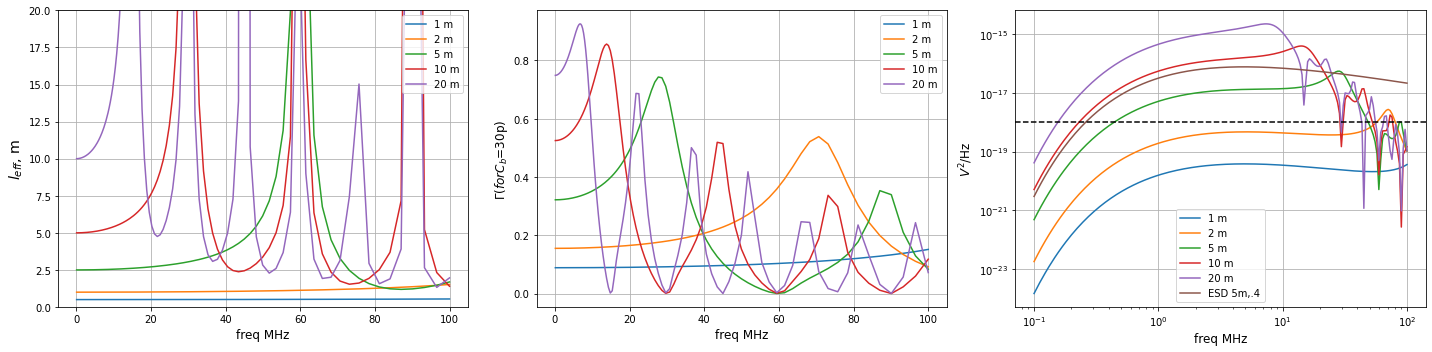

In [9]:
plt.figure(figsize=(20,5))
freq2 = np.logspace(5,8,200) # in Hz
# Lant=np.array([1,4,12])
Lant=np.array([1,2,5,10,20])
for i,L2 in enumerate(Lant):
    label = str(L2)+" m"
    leff2=np.array([leff(L2,_) for _ in freq2])
    gamma2 = np.array([gamma(L2,_) for _ in freq2])
    plt.subplot(131)
    #plt.semilogx(freq2/1e6, leff2)
    plt.plot(freq2/1e6, leff2, label=label)
    plt.ylim(0,L2)
    plt.xlabel('freq MHz', fontsize='large')
    plt.ylabel('$l_{eff}$, m', fontsize='x-large')
    plt.grid(True); plt.legend()

    plt.subplot(132)
    # plt.semilogx(freq2/1e6, gamma2)
    plt.plot(freq2/1e6, gamma2, label=label)
    plt.xlabel('freq MHz', fontsize='large')
    plt.ylabel('$\Gamma ( for C_{b}$=30p)', fontsize='large')
    plt.grid(True); plt.legend()

    plt.subplot(133)
    SNB=B_NB(freq2/1e6)
#          plt.loglog(freq2/1e6,B2V(SNB,freq2, 5,0.4), label='ESD 5m,.4')   # spectrum for ~ESD
    V2 = B2V(SNB,freq2,leff2,gamma2)
    plt.loglog(freq2/1e6, V2, label=label)
    plt.grid(True); plt.legend()
    plt.xlabel('freq MHz', fontsize='large')
    plt.ylabel('$V^2$/Hz', fontsize='large')
    plt.tight_layout()
plt.loglog(freq2/1e6,B2V(SNB,freq2, 5,0.4), label='ESD 5m,.4')   # spectrum for ~ESD
plt.axhline(1e-18, c='k', ls='dashed')
plt.legend()


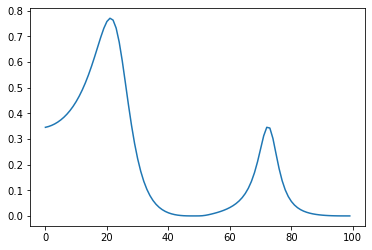

In [10]:
plt.plot((gamma(12,np.linspace(1e6,5e7,100), Cload=30e-12)**2))
# plt.plot((leff(12, np.linspace(1e6,5e7,100)))**2)